<a href="https://colab.research.google.com/github/SaraWijburg/SaraWijburg/blob/main/Copy_of_phybreak_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Outbreak analysis with phybreak

---

Welcome to this practical about the analysis of who infected whom during an infectious disease outbreak. 

 
This practical describes the use of the R package **phybreak** step by step. We will make use of a Google Colab notebook to analyse a SARS-CoV-2 outbreak in the population of Dutch mink farms.  

Please note: Copy this notebook to your own Google Drive. Press 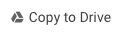 at the top of this page, next to `Code` and `Text`. If you do not have a Google account, it is possible to work in this notebook. However, any changes will be lost. 

## Setting up the R session

---

Before we start this practical we have to set up the R session by installing some packages.  

 

The phybreak package will be downloaded from Github (github.org/bastiaanvdroest/phybreak). With the installation of phybreak, also its dependencies **ape** and **phangorn** will be installed. 

 

Furthermore, we need the packages **gplots** and **phytools** for visualization.  

 

Note: This installation will take around 8 minutes. 

In [ ]:
## Install the phybreak package from Github
devtools::install_github("bastiaanvdroest/phybreak", force = TRUE)

## Install some packages for extra analyses and visualization
install.packages(c("coda", "gplots", "phytools"))

## Load all packages
lapply(c("phybreak", "coda", "gplots", "phytools", "igraph"), require, character.only = TRUE)

In [ ]:
install.packages("tidyverse")
library(tidyverse)

## Loading the data

---

During the installation and loading of the required packages, you can upload the data files in the session memory. Go to Files by pressing the Screenshot 2023-03-08 at 10.11.31.png icon at the left of your screen. Then use 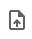 directly under Files, to upload all files from the folder that was provided to you.



After the completion of the installation and loading of the packages, we can proceed with reading in the data. We provided two files with data: 

 

1.   **The sequence data file** (in .fasta format). 

     This file contains the sequences which where sampled at the mink farms. The sequences are stored in fasta format: for each sequence a descriptive line starting with ">" and the sequence in the next line. 

2.   **The metadata file**. This file contains characteristics of the farms. 

 

For analysis with phybreak, it is important that all sequences are aligned and have equal length. 

 

We read the data as following: 

In [2]:
## Read in the sequence data
sequences <- read.dna("sequences.fasta", format = "fasta")

## Read in the metadata
metadata <- read.csv("metadata.csv")
metadata$sampling.date <- as.Date(metadata$sampling.date)

  
## If you want to use your own data, uncomment this part and fill in the paths 
## to the sequence and metadata files

#sequences <- read.dna("[path-to-sequences.fasta]", format = "fasta")
## Sequences in table format, can be translated to DNAbin format:
#sequences <- as.DNAbin(sequences)

#metadata <- read.csv("[path-to-metadatafile.csv]")
#metadata$sampling.date <- as.Date(metadata$sampling.date)

## Show the first twenty rows of 'metadata'
head(metadata, 20)

,sample,farm,sampling.date,latitude,longitude,culling.date,gen.cluster
,<chr>,<chr>,<date>,<dbl>,<dbl>,<chr>,<chr>
1,F1-1,F1,2020-04-24,51.46996,5.564997,2020-06-08,A
2,F1-11,F1,2020-04-24,51.46996,5.564997,2020-06-08,A
3,F1-13,F1,2020-04-24,51.46996,5.564997,2020-06-08,A
4,F1-14,F1,2020-04-24,51.46996,5.564997,2020-06-08,A
5,F1-16,F1,2020-04-24,51.46996,5.564997,2020-06-08,A
6,F1-18,F1,2020-04-24,51.46996,5.564997,2020-06-08,A
7,F1-2,F1,2020-04-24,51.46996,5.564997,2020-06-08,A
8,F1-3,F1,2020-04-24,51.46996,5.564997,2020-06-08,A
9,F1-4,F1,2020-04-24,51.46996,5.564997,2020-06-08,A


In [9]:
## Show the number of rows and columns of metadata data.frame
dim(metadata)
unique(metadata$gen.cluster)
unique(metadata$farm)

[1] 68  7

[1] "A" "D" "B"

[1] "F1"  "F10" "F12" "F13" "F15" "F16" "F18" "F19" "F2"  "F20" "F25" "F28"
[13] "F3"  "F4"  "F5"  "F8b" "F8a"

The output shows the first 20 rows of the metadata table, which contains information about 68 samples. Each row is a sample including its name, the farm from which the sample was taken and at which date the sample was taken. Furthermore, it includes the geographic location (in latitude/longitude coordinates) of the farm and the culling date (i.e. the date that all animals were removed from the farm). In the last column the genetic clusters of a phylogenetic analysis performed by Lu et al. (2021) is added. 

## First view on the data

---

A first approach on analysing an outbreak is to take a look at the genetic sequences of the pathogen. Single Nucleotide Polymorphisms (SNPs) between sequences give information  about the relatedness of sequences and provide a preliminary overview of the clustering of the hosts.  

 

The distance between two sequences is defined as the number of nucleotides in which the sequences are different, i.e. the number of SNPs, between these sequences. 

We cluster the sequences based on their pairwise distance, i.e. distance between two sequences. By visualizing the distances in a heatmap, some genetic clusters can be found in which transmission could have happened. 

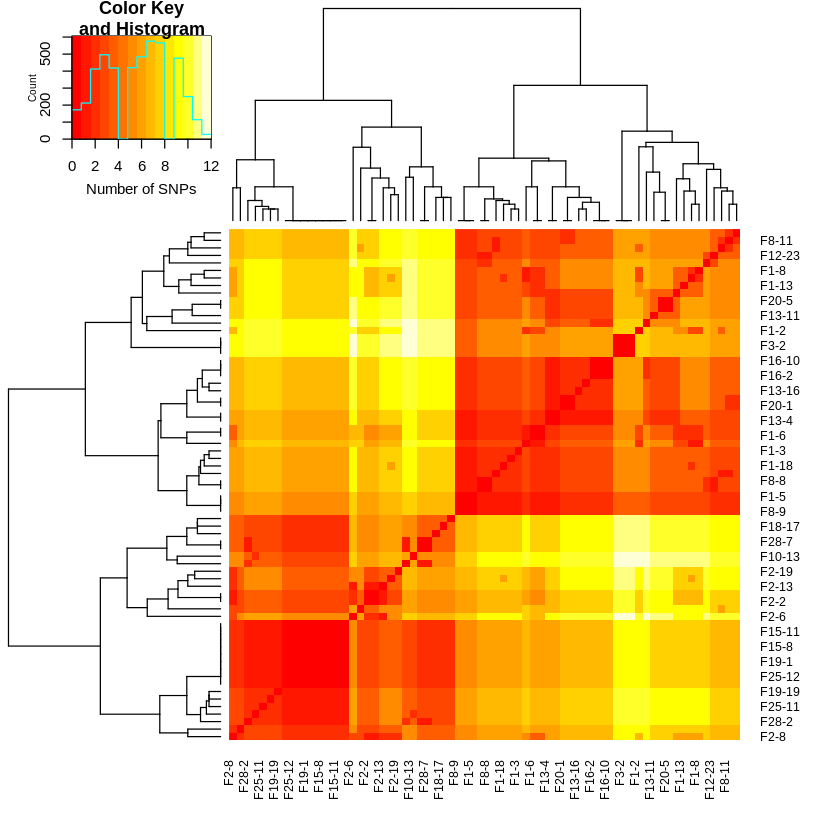

In [3]:
## Create a distance matrix in SNPs, use model = "N" to calculate the SNPs
## between two sequences
sequences.dist <- dist.dna(sequences, model = "N", as.matrix = TRUE)

## Visualize the distance matrix in a heatmap
heatmap.2(sequences.dist, trace = "none", key.xlab = "Number of SNPs")

**Question:** As the color represents the distance between two sequences (with red a distance of 0, i.e. two exact the same sequences), how many genetic clusters do you expect?  


**Answer**: 2 clusters based on the tree. 3 clusters when I look at unique(metadata$gen.cluster) --> A B D 

Now that we have found genetic clusters, which contain possible transmissions, we want to find out direction of these transmissions.

To get some more idea about who infected whom, we can have a look at two types of trees: 



1.   **The minimal spanning tree (MST):** This tree, with as nodes the farms and as edges connections between farms, is used to identify the way of connecting samples with least overall distance.
2.   **The Neighbour Joining Tree (NJ):** This tree has the farms on the end nodes (leaves), and as inner nodes non-sampled sequences. It is used to represent evolutionary relationships between the sequences.


For simplicity of the figures, we are going to use only one sample of each farm:

In [5]:
## Create a distance matrix with one sample per farm
one_sequence <- sequences[!duplicated(metadata$farm),]
one_sequence.dist <- dist.dna(one_sequence, model = "N", as.matrix = TRUE)

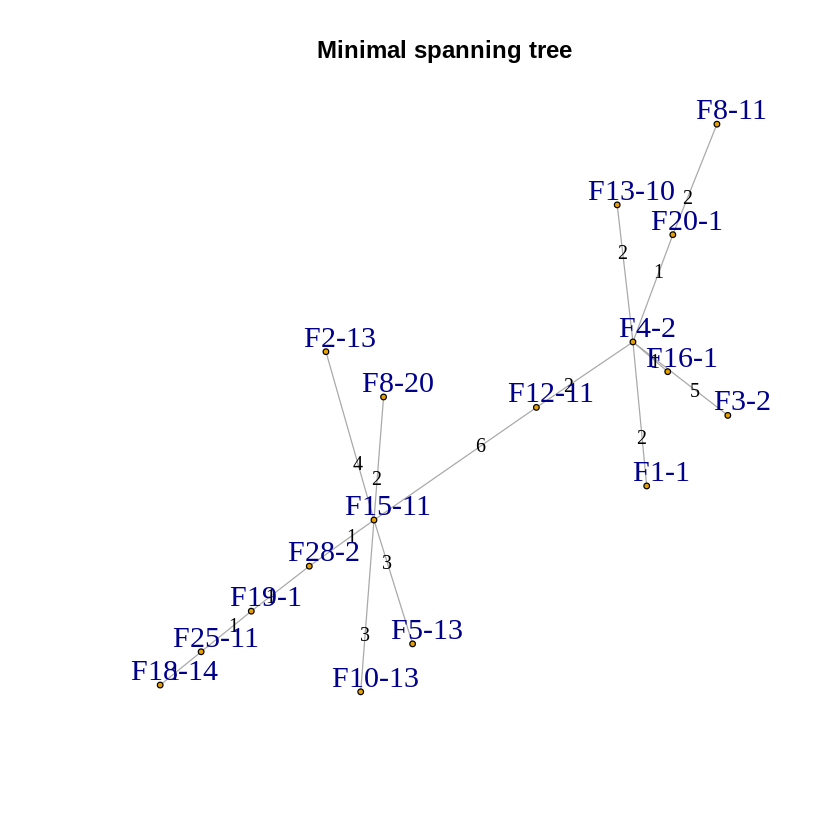

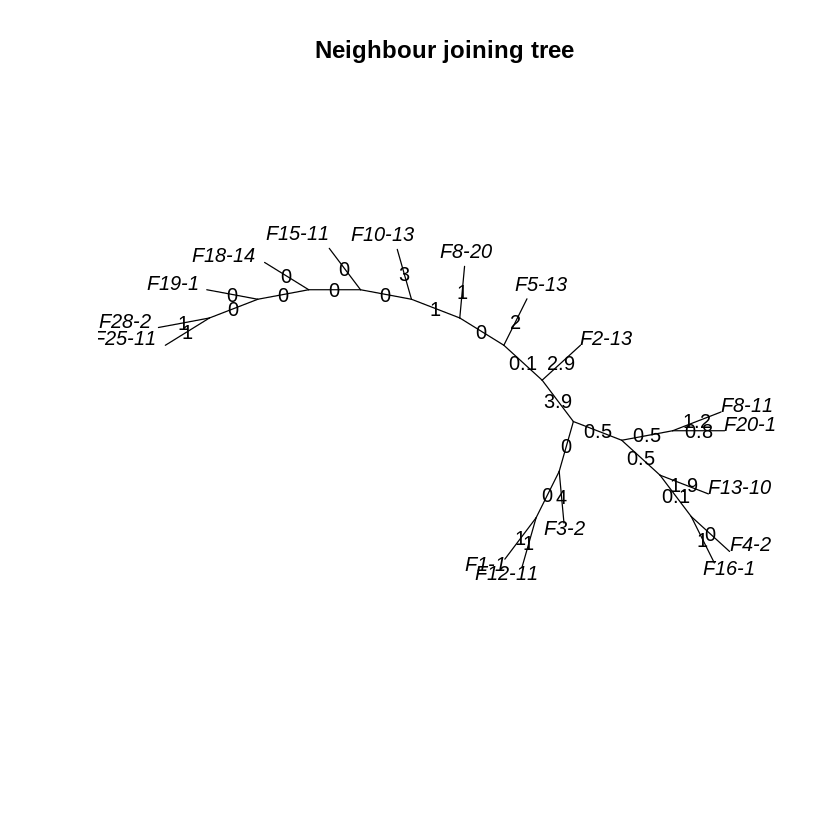

In [13]:
## Make a graph object from the distance matrix
mygraph <- graph.adjacency(one_sequence.dist, weighted = TRUE)

## Compute and plot the minimum spanning tree
mstgraph <- as.undirected(minimum.spanning.tree(mygraph))

## Create a layout where nodes with more distance are further away from each other
layout <- layout_with_fr(mstgraph, weights=1/E(mstgraph)$weight)

plot(mstgraph, 
     layout = layout, 
     edge.label = edge_attr(mstgraph,"weight"),   # Add distance as edge label
     edge.label.color = "black",                  # Color of edge labels
     vertex.size = 2,                             # Size of the nodes
     vertex.label.dist= 1,
     vertex.label.cex = 1.5)                        # Add a little space between the node and its label
title(main = "Minimal spanning tree")

## Compute and plot the Neighbour joining tree
njtree <- nj(one_sequence.dist)

plot(njtree, type = "unrooted", use.edge.length = F)  # Plot without using a starting edge and no edge length for better overview
title(main = "Neighbour joining tree")
edgelabels(round(njtree$edge.length, 1), frame = "none") # Add distance as edge labels



**Difference between the two trees:** In the first tree the nodes are the samples, each label is on a dot (you connect samples together, connection between the different farms because you have one sample per farm). In the second one the labels are on the  --> gives a clearer picture of the evolution of the virus. The highest value here (3.9) represents the break between the two clusters.  

**Question:** 
Can we get any clue on who infected whom in these trees?
- No --> I think they only display sequence distance (Sequence distance = total number of nucleotides different between two sequences (the number of SNPs between two sequences))

**Question:** Rerun the code to create MST and NJ trees, are they the same as in the first run?
- Don't look completely the same 

## Collecting all data into one object


---


After reading the genetic and epidemiological data, we have to collect them in a way that the functions in **phybreak** can work with it.
When there are multiple samples from the same host, the samples have to be linked to their hosts. In the `metadata` object, each sample is linked to a farm, so we can use that column as host names. 

*Note:* For **phybreak** to match a sequence and sampling time, we must enter them in the same order. This is already done in our metadata.

*Note:* In this version of **phybreak** it is only possible to include sequences, sample times, host names and spatial data (lon/lat) of the hosts.

In [16]:
data.object <- phybreakdata(sequences    = sequences,
                            sample.times = metadata$sampling.date,
                            host.names   = metadata$farm)
head(data.object)

$sequences
68 sequences with 16289 character and 68 different site patterns.
The states are a c g t 

$sample.times
        F1-1        F2-13         F3-2         F4-2        F5-13        F8-11 
"2020-04-24" "2020-04-25" "2020-05-07" "2020-05-07" "2020-05-31" "2020-06-02" 
       F8-20       F10-13       F12-11       F13-10       F15-11        F16-1 
"2020-06-02" "2020-06-08" "2020-06-09" "2020-06-14" "2020-06-21" "2020-06-21" 
       F19-1       F18-14        F20-1       F25-11        F28-2        F1-11 
"2020-07-04" "2020-07-05" "2020-07-09" "2020-07-26" "2020-08-08" "2020-04-24" 
       F1-13        F1-14        F1-16        F1-18         F1-2         F1-3 
"2020-04-24" "2020-04-24" "2020-04-24" "2020-04-24" "2020-04-24" "2020-04-24" 
        F1-4         F1-5         F1-6         F1-7         F1-8        F2-19 
"2020-04-24" "2020-04-24" "2020-04-24" "2020-04-24" "2020-04-24" "2020-04-25" 
        F2-2         F2-3         F2-6         F2-7         F2-8         F3-4 
"2020-04-25" "2

## Set up the analysis
---
When we now have a phybreakdata object, it is time to initizalize the analysis. This means that we are given some prior knowledge about the parameter values to the model, and create a phylogenetic tree and a matching transmission tree as starting trees. We can do this with the `phybreak` function. 




In [19]:
MCMC_init <- phybreak(data.object)
MCMC_init

A phybreak object with 0 posterior samples.

The data:
* an outbreak of 17 hosts, named F1, F2, F3, F4, F5, F8b, ...
* the outbreak started 2020-04-24 and ended 2020-08-08
* the data contain 68 sequences, with a total of 60 SNPs

The model:
* generation interval ~ Gamma(shape = 3, mean = 1)
	mean estimated with prior mean = 1 and sd = Inf
* sampling interval ~ Gamma(shape = 3, mean = 1)
	mean estimated with prior mean = 1 and sd = Inf
* within-host model is "linear" with slope = 1
	slope estimated with Gamma prior (shape = 3, mean = 1)
* mutation rate mu = 4.09e-06, estimated with log-uniform prior

By default, the generation time interval distribution will follow a Gamma distribution: a natural choice for time processes. The infectiousness of an infector is distributed according to this distribution. To use the Gamma distribution in the analysis, we can run: 

`MCMC_init <- phybreak(data.object, prior.sample.mean.mean = 10, prior.sample.mean.sd = 1)`

(not runnable as code in this notebook)

For our outbreak, the Gamma distribution is not optimal, as the farms could have been infected and stayed infectious till culling. So we included an infectiousness function which represents this model. This function describes a exponential growth in infectiousness right after infection of a farm. After some time, the infectiousness will become saturated, and it declines again after culling of the farm. 

You can find this function in `infectivity_function.R`. 

 

This infectiousness function also takes the time of culling into account, so we have to load the culling times into the packages memory. 

In [20]:
## Assign the culling times to the package environment
culling.times <- as.Date(metadata$culling.date[match(data.object$sample.hosts[1:18], metadata$farm)])
assign("culling.times", get("culling.times", environment()), phybreak:::userenv)
culling.times

[1] "2020-06-08" "2020-06-07" "2020-06-06" "2020-06-09" "2020-06-09"
 [6] "2020-06-08" "2020-06-08" "2020-06-10" "2020-06-12" "2020-06-15"
[11] "2020-06-22" "2020-06-22" "2020-07-06" "2020-07-07" "2020-07-11"
[16] "2020-07-27" "2020-08-10" "2020-06-08"

The analysis will be initialized by defining prior distributions for parameters that take into account the knowledge we have of these parameters. For instance, Hammer et al. (2021) found that the time between infection and sampling of a farm was 1-2 weeks. So we set `prior.sample.mean.mean = 10` and `prior.sample.mean.sd = 3`: A mean of 10 days with a standard deviation of 3 days.  

Besided the parameter values, we also initialize a phylogenetic and transmission tree, which the model is going to update to find the tree best fitting to the data. 

 

 

In [21]:
MCMC_init <- phybreak(data.object, prior.sample.mean.mean = 10, prior.sample.mean.sd = 3,
                      trans.model = "user-defined", infectivity_file = "infectivity_function.R")
MCMC_init

A phybreak object with 0 posterior samples.

The data:
* an outbreak of 17 hosts, named F1, F2, F3, F4, F5, F8b, ...
* the outbreak started 2020-04-24 and ended 2020-08-08
* the data contain 68 sequences, with a total of 60 SNPs

The model:
* generation interval ~ Gamma(shape = 3, mean = 1)
	mean estimated with prior mean = 1 and sd = Inf
* sampling interval ~ Gamma(shape = 3, mean = 1)
	mean estimated with prior mean = 10 and sd = 3
* within-host model is "linear" with slope = 1
	slope estimated with Gamma prior (shape = 3, mean = 1)
* mutation rate mu = 4e-06, estimated with log-uniform prior

## Running the analysis


---


Now that we have an initial state, we can sample from the posterior distributions using the MCMC algorithm. 
There are two functions available for that, `burnin_phybreak` and `sample_phybreak`. The difference is that the former runs a MCMC chain but only returns the `phybreak` object with the latest state, whereas the latter also samples from the chain and stores these samples.

### Burn-in

Convergence of the MCMC results, will happen after a while, such that we can loose the information in the first cycles. To not include those cycles in the posterior distributions, we first perform a burn-in of 1,000 cycles. By default, the function will show intermediate results every 10 seconds, such that we can keep track of its progress.

*Note:* Results may differ each time you run the cell. This is because of the MCMC chain taking quasi-random samples of the parameters, infectors and infection times.


In [22]:
## Perform a burn-in of the MCMC
MCMC_state <- burnin_phybreak(MCMC_init, ncycles = 1000)
MCMC_state

   cycle      logLik  introductions       mu  gen.mean  sam.mean parsimony (nSNPs = 60)

       0   -32839.56             17    4e-06         1         1        84

     121   -23536.05             13 5.07e-06      21.3      10.8        70

     254   -23506.14             11  7.1e-06        10      9.35        70

     390   -23505.88             12 5.34e-06      16.4      10.7        70

     510   -23503.57             10 5.05e-06      13.6      9.82        70

     638   -23527.67             13 5.06e-06      20.6      8.68        70

     765   -23536.74             14 4.75e-06        27      11.2        70

     889   -23569.27             12 4.94e-06      21.9      12.2        70



A phybreak object with 0 posterior samples.

The data:
* an outbreak of 17 hosts, named F1, F2, F3, F4, F5, F8b, ...
* the outbreak started 2020-04-24 and ended 2020-08-08
* the data contain 68 sequences, with a total of 60 SNPs

The model:
* generation interval ~ Gamma(shape = 3, mean = 15.8483)
	mean estimated with prior mean = 1 and sd = Inf
* sampling interval ~ Gamma(shape = 3, mean = 8.04445)
	mean estimated with prior mean = 10 and sd = 3
* within-host model is "linear" with slope = 8.57
	slope estimated with Gamma prior (shape = 3, mean = 1)
* mutation rate mu = 5.92e-06, estimated with log-uniform prior

### Sampling
After the burn-in period, we are sampling the model parameters, the infectors and infection times from the posterior distributions. We run 10,000 cycles (`1e4`) in order to have enough samples to calculate the estimated values. This will take about 10 minutes to process, so we provided a `mcmc_samples.rds` file with the result of this command. 


In [23]:
## To run the MCMC chain with 10,000 cycles
## The `nchains = 3` argument tells the model to use 3 parallel chains, in order
## to find the most optimal state

# MCMC_state <- sample_phybreak(MCMC_state, nsample = 1e4, nchains = 3)

## To load the prerun MCMC chain provided as .rds file
MCMC_state <- readRDS("mcmc_samples.rds")
print(MCMC_state)

A phybreak object with 10000 posterior samples.

The data:
* an outbreak of 17 hosts, named F1, F2, F3, F4, F5, F8b, ...
* the outbreak started 2020-04-24 and ended 2020-08-08
* the data contain 68 sequences, with a total of 60 SNPs

The model:
* generation interval ~ Gamma(shape = 3, mean = 19.1668)
	mean estimated with prior mean = 1 and sd = Inf
* sampling interval ~ Gamma(shape = 3, mean = 11.8654)
	mean estimated with prior mean = 10 and sd = 1
* within-host model is "linear" with slope = 8.47
	slope estimated with Gamma prior (shape = 3, mean = 1)
* mutation rate mu = 4.63e-06, estimated with log-uniform prior

## Analyze the results


---



After running `sample_outbreak`, the `phybreak` object contains samples from the MCMC-chain. We can use the functionality of the **coda** package to analyse the chain, e.g. making trace plots, calculating effective sample sizes (ESS), and calculating summary statistics of the parameters and (continuous) variables.

mu introductions            mG            mS      wh.slope 
   221.126108     50.621187    351.626984    175.860939    227.403320 
   wh.history       tinf.F1       tinf.F2       tinf.F3       tinf.F4 
   245.493439     25.984139    116.344937     63.770239    136.601661 
      tinf.F5      tinf.F8b      tinf.F8a      tinf.F10      tinf.F12 
   189.076187     12.150950    100.162387    206.816664     54.674342 
     tinf.F13      tinf.F15      tinf.F16      tinf.F19      tinf.F18 
   245.752387    250.453240    607.737985     14.007994    121.845732 
     tinf.F20      tinf.F25      tinf.F28   infector.F1   infector.F2 
     0.000000    169.183596      5.471449      0.000000     15.905488 
  infector.F3   infector.F4   infector.F5  infector.F8b  infector.F8a 
   425.339545   1099.137467    127.436926      9.635591    165.630766 
 infector.F10  infector.F12  infector.F13  infector.F15  infector.F16 
    37.224925      0.000000    725.152459    115.955927    598.315229 
 infector.F19  infector.F18  infector.F20  infector.F25  infector.F28 
    40.905740     64.176462      0.000000    163.347344      0.000000 
       logLik 
   190.756836

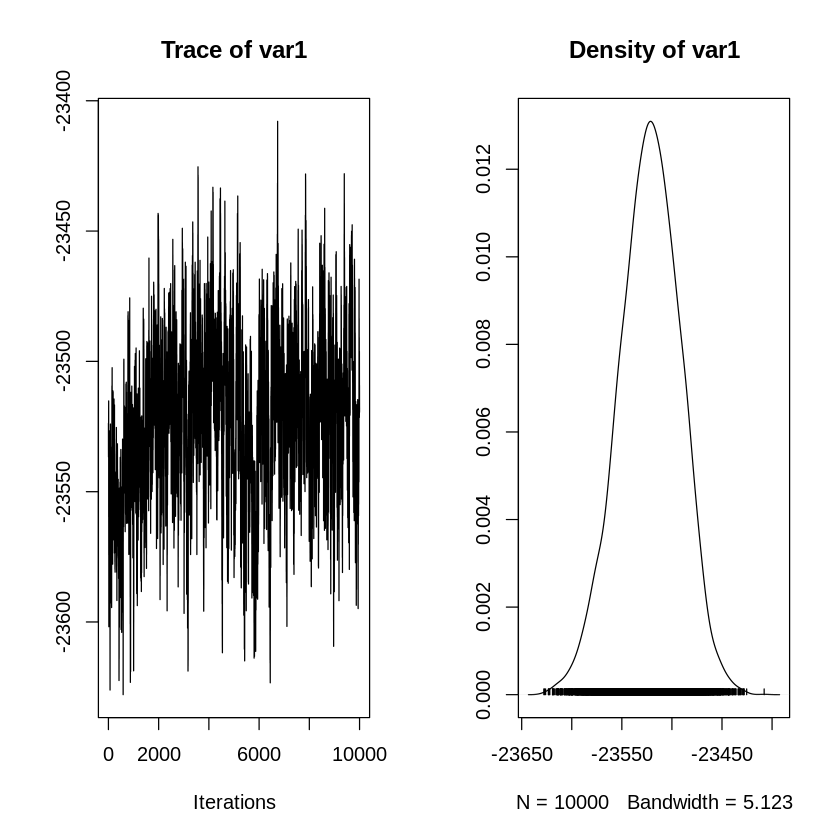

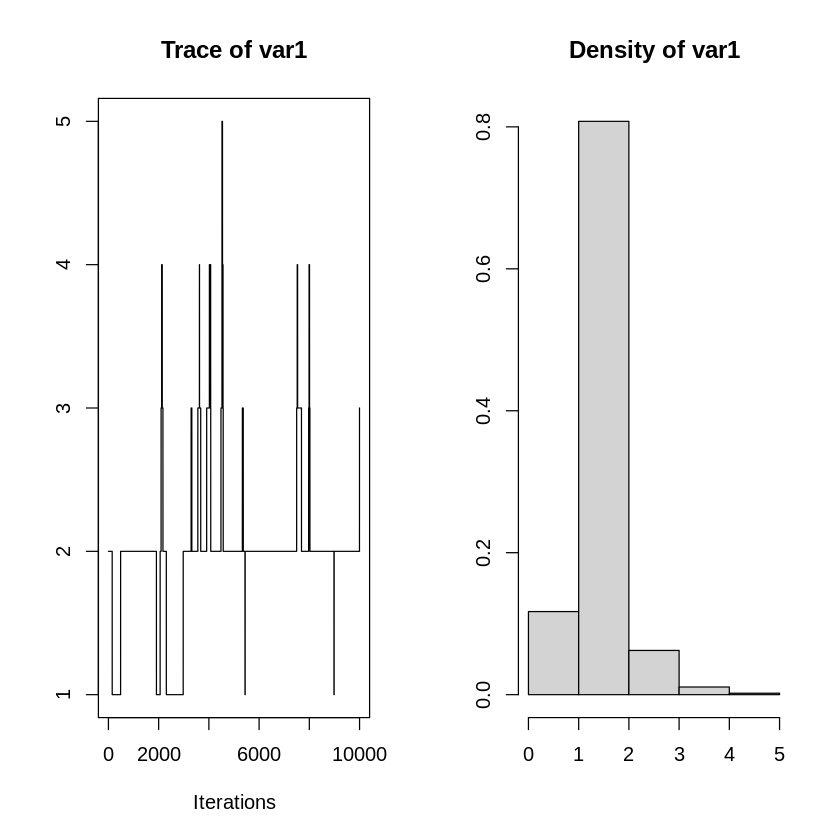

In [25]:
mcmc <- get_mcmc(MCMC_state)
effectiveSize(mcmc)
plot(mcmc[,c("logLik")])
plot(mcmc[,c("introductions")])

**Question:** By changing `"logLik"` into `"introductions"` you can plot the trace and density plots of the number of introductions. How many introductions do you expect based on these plots?

In the density plots, discrete values on the x-axis are given by the number at the right side of the bar. This means that the first bar in the introductions density plot represent 1 introduction.

**Bovenste figuren**: stappen in Monte Carlo plot 

**Answer**: I expect two introductions based on the density plot. In het algemeen blijft het op twee, soms schiet het naar andere waarden. 80% van alle bomen, heeft twee introducties. 

Besides trace and density plots, we can also calculate the empirical mean and standard deviation of the parameters, along with their quantiles.

In [26]:
summary(mcmc[,c("mu")])


Iterations = 1:10000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     4.700e-06      7.371e-07      7.371e-09      4.957e-08 

2. Quantiles for each variable:

     2.5%       25%       50%       75%     97.5% 
3.412e-06 4.172e-06 4.651e-06 5.184e-06 6.257e-06 


**Question:** What is the mean and standard deviation of the mean sampling time (`mS`)?

Mean: 4.700e-06

SD: 7.371e-07

### Tree summmary

The prime summaries from the analysis are the consensus transmission trees: who was infected by whom, obtained through `transtree`. There are multiple ways to compute this tree. 

 

1.    Using the Edmonds' algorithm (`method = edmonds`), as described in [Klinkenberg et al. (2017)](http://dx.doi.org/10.1371/journal.pcbi.1005495). This algorithm bases its choice of infectors on their support, i.e. how many times the infector appeared as infector in the MCMC-chain, and avoids circular relations (e.g. two farms infecting each other). This transmission tree does not have to be one of the trees in the MCMC-chain. Therefore, it does not always have a underlying phylogenetic tree. 

3.    The maximum parent credibility (MPC, `method = mpc`) tree is that tree among the sampled trees with maximal sum of the support of all infectors. Because it is one of the sampled trees, it does come with a matching phylogenetic tree. 

 

In order to get a phylogenetic tree as output, we are going to use the MPC-tree in this practical, although it may have lower support for the infectors compared to the Edmonds' consensus tree.  

 

The results of `transtree` is a data frame with for each host its infector, support of that infector and the infection time (with 95% credible interval). 

In [27]:
transtree(MCMC_state, method = "mpc")

,infector,support,inf.times.Q2.5,inf.times.Q50,inf.times.Q97.5
,<chr>,<dbl>,<date>,<date>,<date>
F1,index,1.0000,2020-03-19,2020-04-06,2020-04-11
F2,index,0.8829,2020-04-03,2020-04-10,2020-04-17
F3,F1,0.9935,2020-04-26,2020-05-02,2020-05-05
F4,F1,0.9971,2020-04-20,2020-04-29,2020-05-05
F5,F2,0.5292,2020-05-01,2020-05-18,2020-05-28
F8b,F1,0.7498,2020-05-03,2020-05-16,2020-05-23
F8a,F2,0.4910,2020-05-02,2020-05-18,2020-05-30
F10,F5,0.4151,2020-05-20,2020-05-29,2020-06-04
F12,F8b,1.0000,2020-05-20,2020-05-29,2020-06-03


The table above shows for each host the infector in the MPC-tree. It is also possible to see the other infectors of a host found in the sampled trees.

In [28]:
## Show all infectors of Farm 8a, and their support
infectorsets(MCMC_state, which.hosts = "F8a")

infector,support
<chr>,<dbl>
F2,0.4910
F5,0.4799


### Tree visualization

Another way to look at the consensus transmission trees is to plot the transmission or phylogenetic tree (or both in the same figure). 

A transmission tree figure has the farms on the y axis and time on the x axis. Arrows represents transmission or introduction, and the crosses are the sampling times. 

For a consensus tree, the `plotTrans` function will show the support of the transmission link as a colored arrow.

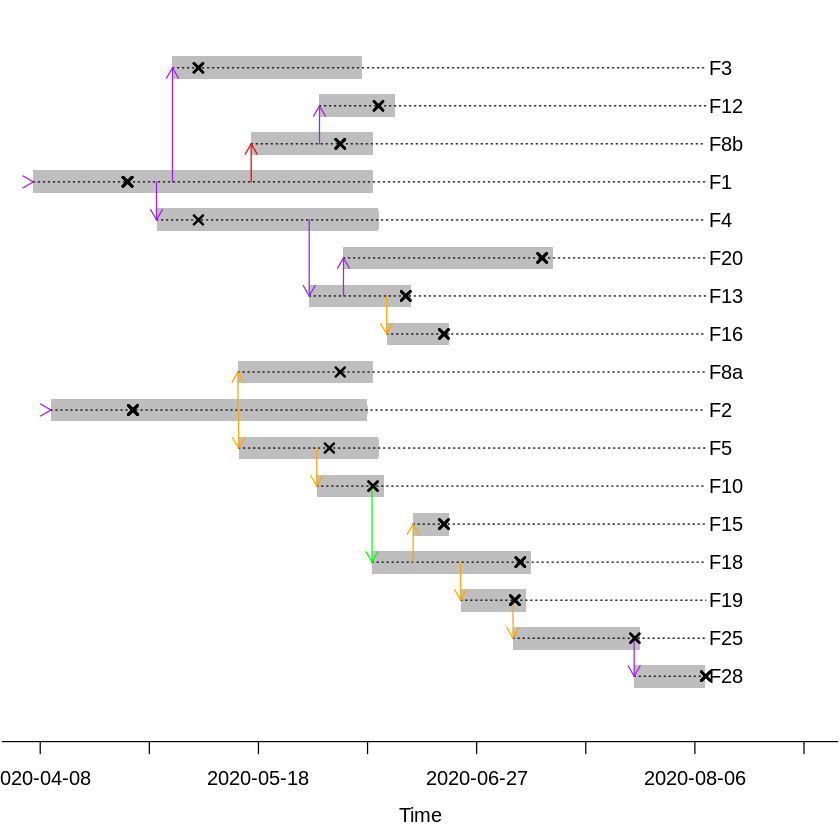

In [33]:
plotTrans(MCMC_state, plot.which = "mpc", samplenr = 0)

**Question:** Can you find in the help of the plot function (`?plotTrans`) what support the colors represent?

**Question:** Plot transmission trees of different samples of the posteriors (change `samplenr = ...`). What differences are there?

In [52]:
?plotTrans

**arrow.col**: Arrow colour. Defaults to ‘"black"’ if ‘plot.which =
          sample’, and otherwise to five colours ‘c("blue", "green",
          "orange", "red", "purple")’ indicating posterior support of
          infectors in bins of 0.2 width, from low to high support. Any
          vector of colours will be divided into equal-sized bins.

**Support:** geeft de fractie weer van cycles die hij doet (updates). 5000 cycles = 5000 bomen. Dan gaat hij steeds kijken hoevaak de link tussen boederij 1 en 2 voorkomt. Bij paars betekent het in 80% van de bomen deze link voorkomt. Aan de hand daarvan kan je de gemiddelde boom berekenen. 

**De grijze bar** = infectiouness curve, where they end = moment of culling. 

**x-sign** = moment of sampling


In [ ]:
plotTrans(MCMC_state, samplenr = 1)

In [ ]:
plotTrans(MCMC_state, plot.which = "mpc", samplenr = 7)

In [ ]:
plotTrans(MCMC_state, plot.which = "mpc", samplenr = 9)

The phylogenetic plot has time at the x axis, and no information on the y axis. The alternating colors represent new hosts, such that every change in color represent a transmission between two hosts. The first red line represent the history host. 

In [ ]:
## Plot the phylogenetic tree with maximum parent credibility
plotPhylo(MCMC_state, plot.which = "mpc", samplenr = 0)

**Question:** Can you find the number of index cases in this phylogenetic tree?

**Answer:** Ja, rood is de geschiedenis voordat het in de boederij terecht komt. Daarna veranderd de kleur in blauw. Dus twee index cases. 


These two figures can even be combined into one, where the phylogenetic mini-trees of each host is plotted. Transmission are now given by the dashed lines between farms.

*Note:* The color blocks of the farms stop at the last sample/transmission. It colors the phylogenetic mini-tree of the host, and does not give any information about the infectiousness of a farm.

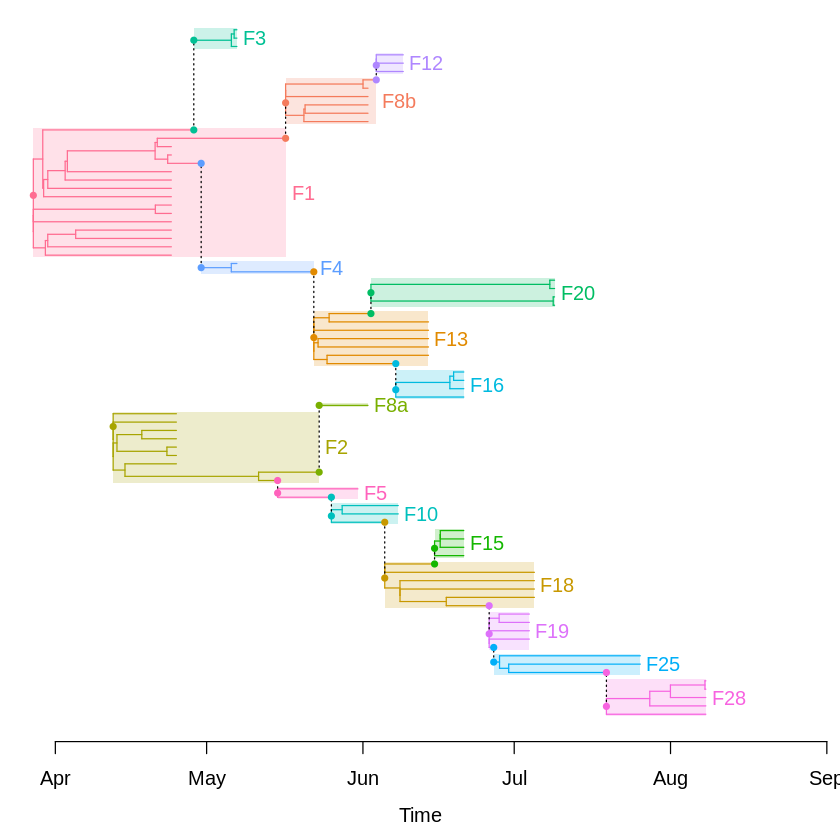

In [49]:
plotPhyloTrans(MCMC_state, plot.which = "mpc")

Je kan hierin zien dat elke boederij een mini boom heeft. F1 en F2 zijn de index boederijen. Vanuit deze boederijen zie je dat andere boederijen besmet raken. F4 and F8b hebben dus een sequentie die redelijk veel op elkaar lijken, vanwege de late vertakking in F1.



We can now also compare our results with the phylogenetic analysis of Lu et al. (2021). They found 3 genetic clusters within this set of farms, which are included in the metadata table: column `metadata$gen.cluster`. As we assign a color to each of the 3 clusters and plot a transmission tree with colored labels, we can compare our results with these genetic clusters.

In [50]:
## Select three colorblind friendly colors
colors <- c("#000000", "#E69F00", "#56B4E9")

## Color the farms (hosts) according to the genetic clusters.
host.color <- sapply(unique(data.object$sample.hosts), function(n){
  cluster <- metadata$gen.cluster[metadata$farm == n][1]
  if (cluster == "A") color <- colors[1]
  else if (cluster == "B") color <- colors[2]
  else if (cluster == "D") color <- colors[3]
  return(color)
})

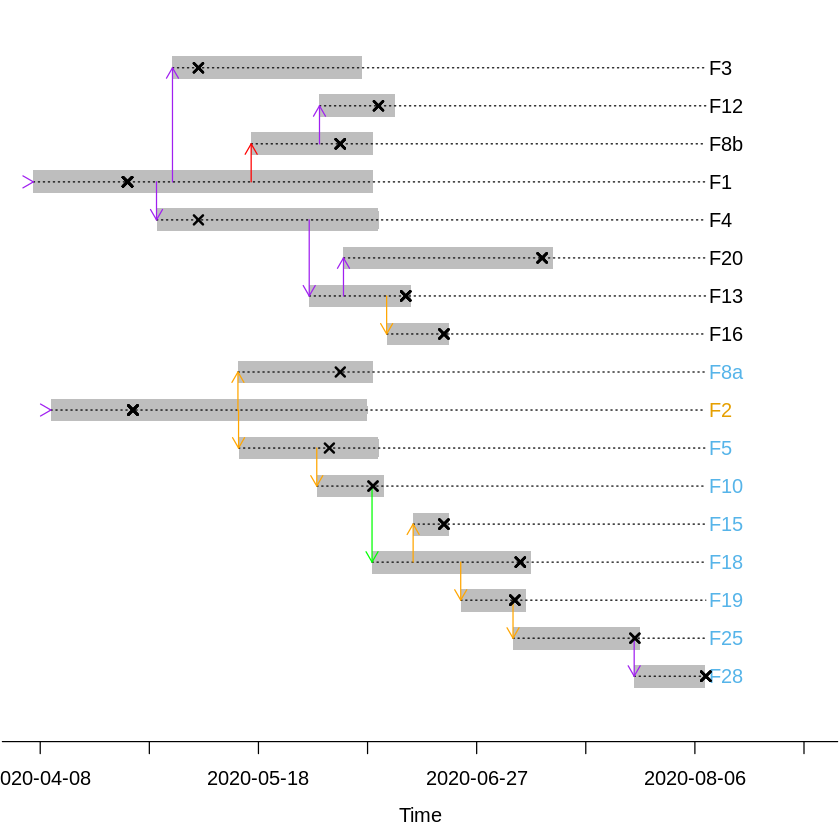

In [51]:
## Plot the transmission tree (the MPC tree) for which the labels are colored.
plotTrans(MCMC_state, plot.which = "mpc", label.col = host.color)

**Question:** Compare the transmission tree of our analysis and the genetic clusters of Lu et al. (the colored labels in the figure), do you find similiarities and/or differences? Can you explain any differences?

**Answer:** De zwarte cluster komt voor uit F1, 
De blauwe cluster lijkt voort te komen uit F2, maar F2 zit niet in de blauwe cluster. F2 clustert wel samen met blauwe cluster. Maar gebasseerd op de genetica kan je verwachten dat F2 wel bij de blauwe cluster hoort. 

**F8a en F8b** --> twee lineages in een host. Scheiden van de sequenties waardoor je kan zien dat beide lineages in twee verschillende clusters zitten. 